In [1]:
import math
import random
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
from dataclasses import dataclass
from typing import List

class Value:
    def __init__(self, data , previous = (), label = '', operation = ''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self.operation = operation
        self.previous = set(previous)
        
        self.propagate_backward = lambda : None

    def backward(self):
        topological_sort : List[Value] = []
        visited = set()
        self.grad = 1.0
        def build_topological_graph(node: Value):
            if node not in visited:
                visited.add(node)
                for child in node.previous:
                    build_topological_graph(child)
                topological_sort.append(node)

        build_topological_graph(self)

        for item in reversed(topological_sort):
            item.propagate_backward()

    def relu(self):
        relu_grad = self.data if self.data > 0 else 0
        output = Value(self.data, label='relu', operation='relu', previous = (self, ))

        def backward():
            self.grad += relu_grad * output.grad
        output.propagate_backward = backward
        return output

    def tanh(self):
        x = self.data
        a = math.exp(2*x)
        t = (a-1)/(a+1)
        output = Value(t, label='tanh', previous=(self,))

        def backward():
            self.grad += (1 - t**2)*output.grad

        output.propagate_backward = backward
        return output

    def __repr__(self) -> str:
        return f"Value(Label: {self.label}, data={self.data}, grad = {self.grad})"

    def __add__(self, other):
        other =  other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, previous= (self, other), operation = '+' )

        def backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad

        output.propagate_backward = backward

        return output

    def __pow__(self, other):
        assert isinstance(other, (float, int)), f"{other} could be only float or int"
        output = Value(self.data ** other, previous = (self, ), operation = '**' )

        def backward():
            self.grad += other * (self.data) * (other - 1) * output.grad
        output.propagate_backward = backward

        return output

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return  self + (-other)

    def __truediv__(self, other):
        return self * (other**-1.0)

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other        

    def __mul__(self, other):
        other =  other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, previous = (self, other), operation = '*' )

        def backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad

        output.propagate_backward = backward
        return output

In [3]:
from graphviz import Digraph

from typing import Tuple, Set

def build_nodes_and_edges(root: Value):
    nodes: Set[Value] = set()
    edges: Set[ Tuple(Value, Value) ] = set()

    def build_network(value: Value):
        if value not in nodes:
            nodes.add(value)
            for child in value.previous:
                edges.add((child, value))
                build_network(child)

    build_network(root)
    return nodes, edges

def visualize_graph(node: Value):
    digraph = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = build_nodes_and_edges(node)

    for node in nodes:
        uid = str(id(node))
        #"{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad)
        digraph.node(uid, label = "{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad),  shape='record' )

        if node.operation :
            opnode_name = uid + str(node.operation)
            digraph.node( opnode_name, f"{node.operation}")
            digraph.edge(opnode_name, uid)
            #digraph.edge(uid, opnode_name)

    for (v1,v2) in edges:
        v1_id = str(id(v1))
        v2_id = str(id(v2)) + v2.operation
        digraph.edge(v1_id, v2_id)

    return digraph


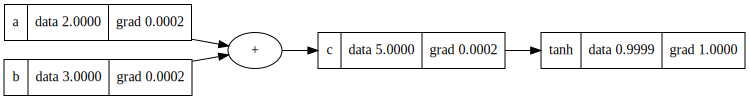

In [4]:
a = Value(2, label = 'a')
b = Value(3, label='b')
c = a + b
c.label = 'c'
d = c.tanh()
d.backward()
visualize_graph(d)

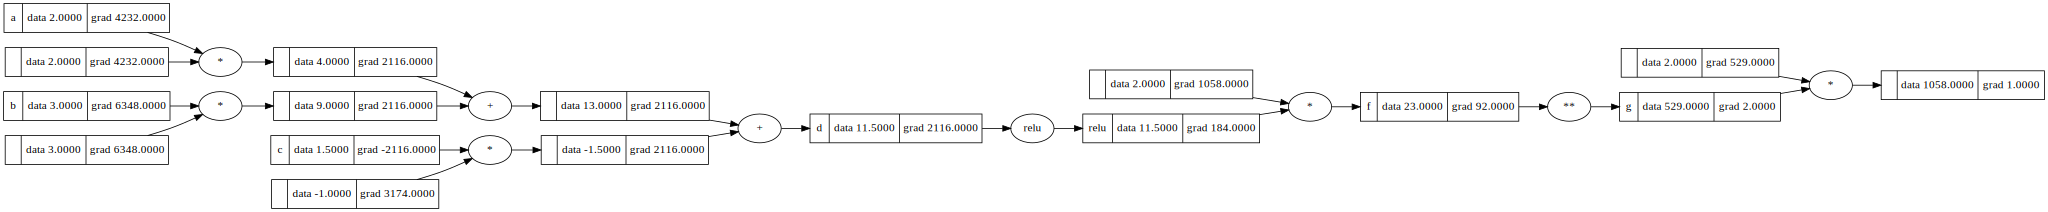

In [5]:
a = Value(2, label='a')
b = Value(3, label='b')
c = Value(1.5, label='c')
d = a*2 + b * 3 - c; d.label = 'd'
e = d.relu()
f = 2*e #+  c #+ 2 * a
f.label = 'f'
g = f ** 2 
g.label = 'g'

h = g * 2
h.grad = 1.0

h.backward()
visualize_graph(h)
# print(f.data, e.data, d.data, c.data, b.data, a.data)
# print(f.grad, e.grad, d.grad, c.grad, b.grad, a.grad)

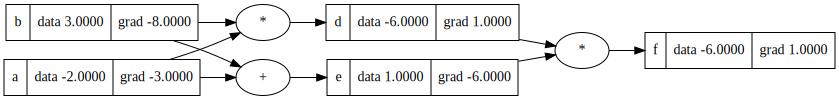

In [6]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

visualize_graph(f)

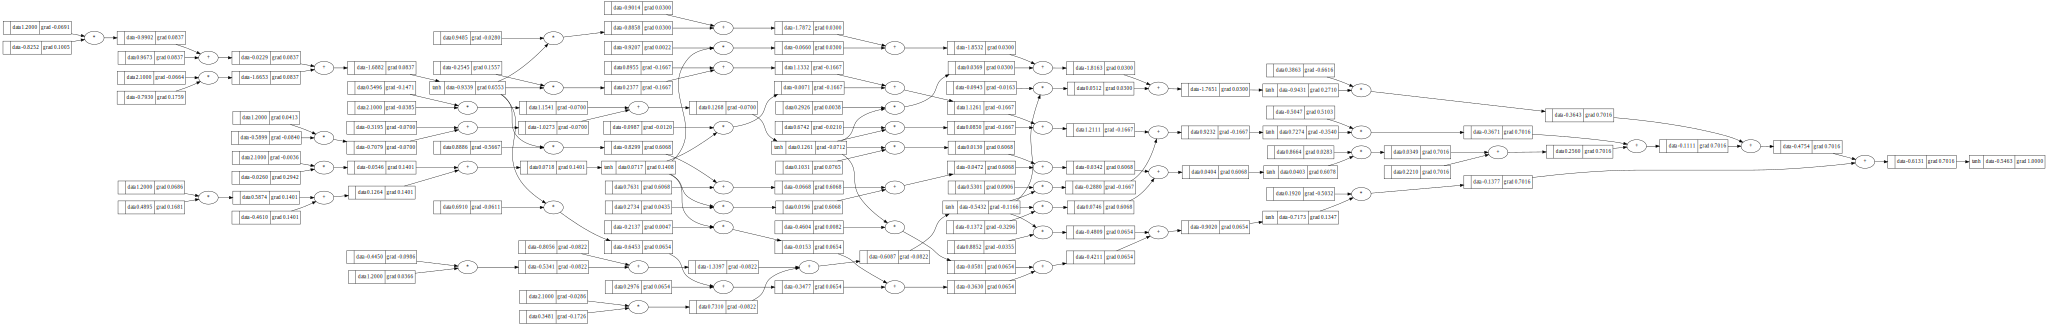

In [7]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = [ Value(random.uniform(-1.0, 1.0) ) for i in range(n_inputs) ]
        self.bias = Value(random.uniform(-1.0, 1.0) )

    def __call__(self, x):
        result = sum( (wi*xi for (wi,xi ) in zip(self.weights, x) ), self.bias)
        return result.tanh()

    def parameters(self):
        return [self.bias] + self.weights

class Layer:
    def __init__(self, n_inputs, n_outputs):
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]

    def __call__(self, x):
        return [ neuron(x) for neuron in self.neurons]

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters() ]

class MultiLayerPerceptron:
    def __init__(self, n_inputs: int, layers_output: List[int] ):
        sz = [n_inputs] + layers_output
        self.layers = [Layer( sz[i], sz[i+1] ) for i in range( len(layers_output))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters() ]

    def zero_gradient(self):
        for param in self.parameters():
            param.grad = 0.0

    def step(self, step_size:float = 0.01):
        for param in self.parameters():
            param.data += -step_size * param.grad

def print_neuron(n : Neuron, x: any):
    act = n(x)
    justify_len = 50
    def print_internal(value: Value, level: int):
        print(f"L: {level}, data: {value.data}, grad: {value.grad}".rjust(justify_len + 2 * (level-1)))
        for child in value.previous:
            print_internal(child, level+1)
    print_internal(act, 1)

n = Neuron(2)
#print(len(n.parameters()))
#print_neuron(n, x)

x = [1.2, 2.1]
mlp = MultiLayerPerceptron(2, [4,4,1])

#print(len(mlp.parameters()))

z = mlp(x)
mlp.zero_gradient()
z.backward()

visualize_graph(z)


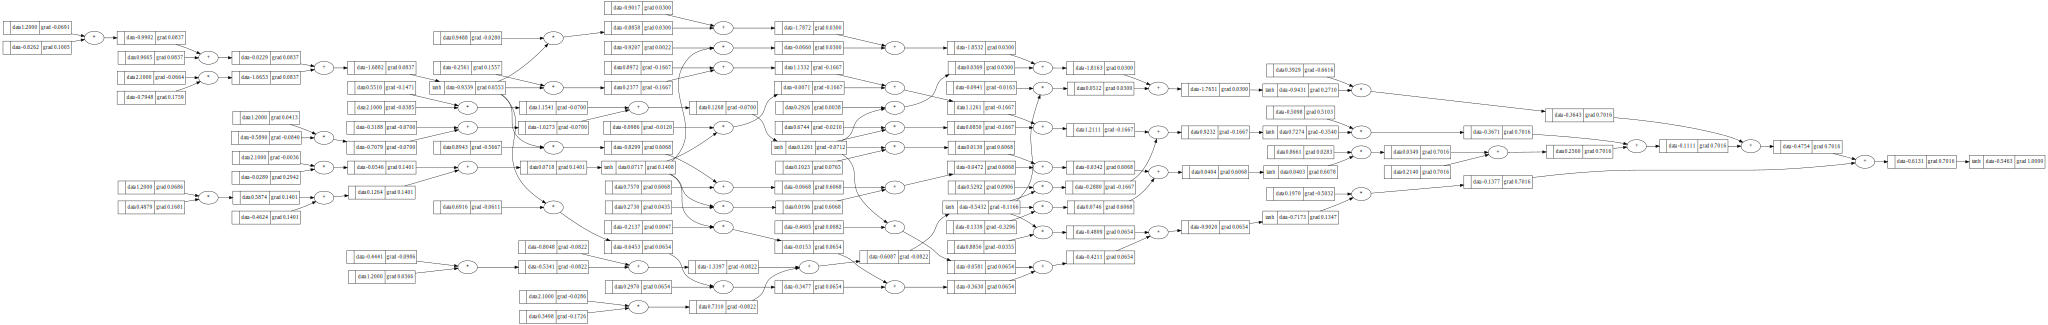

In [8]:
mlp.step(0.01)

visualize_graph(z)

4.088056179949465
3.819328808644319
3.5803737733027354
3.365024829059566
3.1684020991542035
2.9866846392293054
2.8169277738194447
2.6569029692876747
2.504962842566292
2.359931765648878
2.221017325675245
2.0877359026692606
1.959846492954223
1.8372891509428022
1.7201268977542368
1.6084919450440687
1.5025382324425336
1.4024024841610174
1.30817540708295
1.2198835974201874


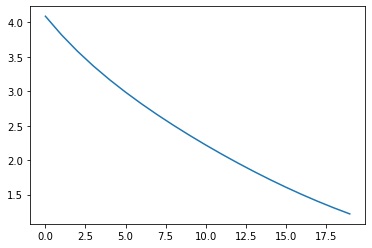

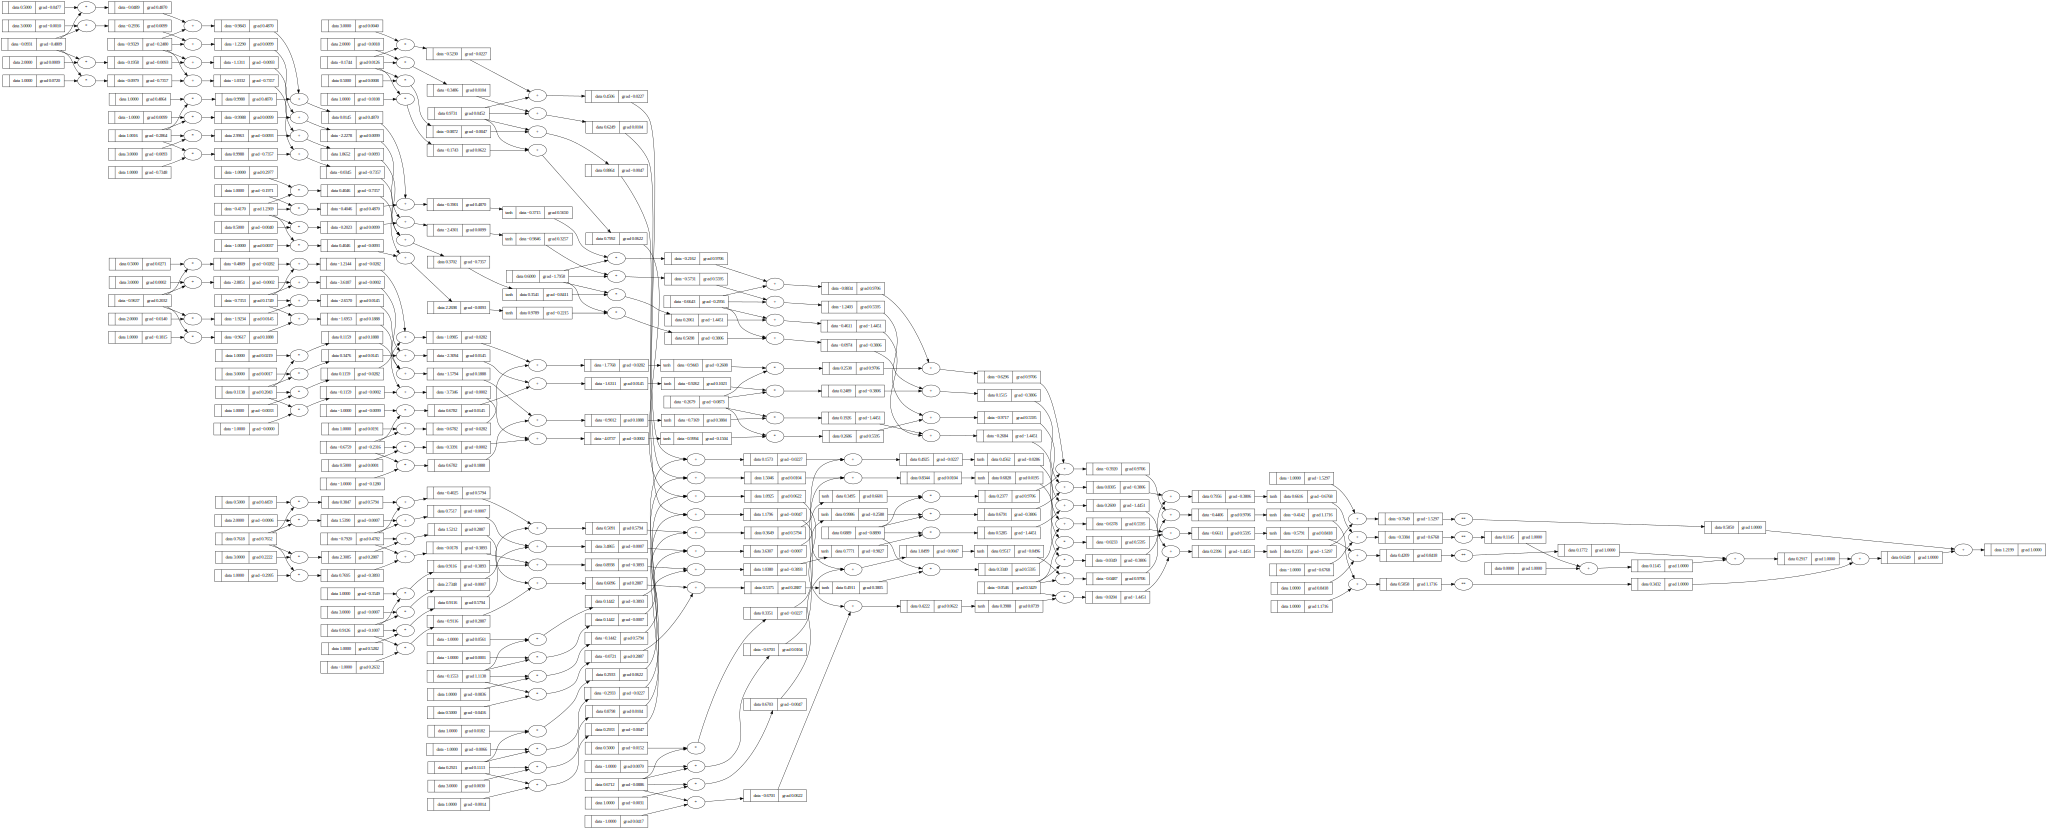

In [9]:
mlp = MultiLayerPerceptron(3, [4,1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

epoch_count = 20
losses = []

for epoch in range(epoch_count):
    y_pred = [ mlp(x) for x in xs ]
    loss = sum((yp - y)**2 for (yp, y) in zip(y_pred, ys))
    mlp.zero_gradient()
    loss.backward()
    mlp.step()
    print(loss.data)
    losses.append(loss.data)

plt.plot(np.arange(epoch_count), losses)
plt.show()

visualize_graph(loss)
